# Lysozyme + Mutations tutorial using BIOBB
Based on the oficial Gromacs tutorial: http://www.mdtutorials.com/gmx/lysozyme/01_pdb2gmx.html

In [31]:
import os
import sys
import nglview
import ipywidgets
from pathlib import Path

def showlog(out_log='log.out', error_log='log.err', n_lines=20, nerror_lines=1, delete=True):
    with open(out_log) as f:
        cont=1
        for line in f:
            if cont > n_lines: break
            print(line, end='')
            cont +=1
    if delete:
        os.remove(out_log)
        
    if Path(error_log).exists():
        with open(error_log) as f:
            cont=1
            for line in f:
                if cont > nerror_lines: break
                print(line, end='')
                cont +=1
        if delete:
            os.remove(error_log)


## Dowload the initial Structure
Download the initial PDB file from a PDB code (1AKI) from the IRB (http://mmb.irbbarcelona.org/api) REST API.
The PDB will be dowloaded without solvent or HETATM.

In [32]:
#Download PDB
#Import module
from biobb_io.mmb_api.pdb import MmbPdb
# Create prop dict and inputs/outputs
prop = {'pdb_code':'1aki'}
downloaded_pdb_path = '1aki.pdb'
#Create and launch bb
MmbPdb(output_pdb_path=downloaded_pdb_path, properties=prop).launch()
#Show log and protein
showlog()
view = nglview.show_file(downloaded_pdb_path)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view

2018-11-21 12:22:31,394 [MainThread  ] [INFO ]  
Downloading:
pdb_code: 1aki
from: http://mmb.irbbarcelona.org/api/pdb/1aki/coords/?filter=/1&group=ATOM
2018-11-21 12:22:31,673 [MainThread  ] [INFO ]  
Writting: 1aki
to: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/1aki.pdb


NGLWidget()

## Modeling the missing heavy atoms in the structure side chains
This BB will reconstruct missing atoms from residue side chains and detect all kinds of clashes

In [33]:
#Check & Fix PDB
#Import module
from biobb_model.model.fix_side_chain import FixSideChain
# Create prop dict and inputs/outputs
fixed_pdb_path = '1aki_fixed.pdb'
#Create and launch bb
FixSideChain(input_pdb_path=downloaded_pdb_path, output_pdb_path=fixed_pdb_path, properties={}).launch()
#Show log and protein
showlog(n_lines=30)
view = nglview.show_file(fixed_pdb_path)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

=                     MDWeb structure checking utility                        =
=                      A. Hospital, J.L. Gelpi 2018                           =

Running fixside. Options: --fix All 
1aki.pdb
Structure 1aki.pdb loaded
Title: 
Experimental method: unknown
Resolution: 0.0 A

 Num. models: 1
 Num. chains: 1 (A: Protein)
 Num. residues:  129
 Num. residues with ins. codes:  0
 Num. HETATM residues:  0
 Num. ligands or modified residues:  0
 Num. water mol.:  0
 Num. atoms:  1001

No residues with missing side chain atoms found
Structure not modified, saving due to --force_save option
Structure saved on 1aki_fixed.pdb
Final Num. models: 1
Final Num. chains: 1 (A: Protein)
Final Num. residues:  129
Final Num. residues with ins. codes:  0
Final Num. HETATM residues:  0
Final Num. ligands or modified residues:  0


NGLWidget()

## Modeling mutation list
This BB will mutate existing residues to the requested ones.

In [34]:
#Mutate protein
# Import module to test
from biobb_model.model.mutate import Mutate
# Create prop dict and inputs/outputs
prop = {'mutation_list': 'Val2Tyr'}
mutated_pdb_path = '1aki_mutated.pdb'
#Create and launch bb
Mutate(input_pdb_path=fixed_pdb_path,output_pdb_path=mutated_pdb_path, properties=prop).launch()
#Show log and protein
showlog(n_lines=100)
view1 = nglview.show_file(fixed_pdb_path)
view1.add_representation(repr_type='ball+stick', selection='2:A')
view1._remote_call('setSize', target='Widget', args=['500px','600px'])
view1.camera='orthographic'
view2 = nglview.show_file(mutated_pdb_path)
view2.add_representation(repr_type='ball+stick', selection='2:A')
view2._remote_call('setSize', target='Widget', args=['500px','600px'])
view2.camera='orthographic'
ipywidgets.HBox([view1, view2])

=                     MDWeb structure checking utility                        =
=                      A. Hospital, J.L. Gelpi 2018                           =

Running mutateside. Options: --mut Val2Tyr 
1aki_fixed.pdb
Structure 1aki_fixed.pdb loaded
Title: 
Experimental method: unknown
Resolution: 0.0 A

 Num. models: 1
 Num. chains: 1 (A: Protein)
 Num. residues:  129
 Num. residues with ins. codes:  0
 Num. HETATM residues:  0
 Num. ligands or modified residues:  0
 Num. water mol.:  0
 Num. atoms:  1001

Mutations to perform
*:VAL2TYR
Replacing VAL A2 into TYR
  Renaming CG1 to CG
  Deleting CG2
  Adding new atom CD1
  Adding new atom CE1
  Adding new atom CZ
  Adding new atom OH
  Adding new atom CE2
  Adding new atom CD2

Checking new clashes
No severe clashes detected
1 Steric apolar clashes detected
 TYR A2.CE2   PHE A38.CB      2.767 A
No polar_acceptor clashes detected
No polar_donor clashes detected
No positive clashes detected
No negative clashes detected
Structure saved o

## Generate the topology
Generate the topology using [Pdb2gmx](http://manual.gromacs.org/programs/gmx-pdb2gmx.html) module.
The default forcefield is [amber99sb-ildn](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2970904/) and the default water_type is [spce](http://www.sklogwiki.org/SklogWiki/index.php/SPC/E_model_of_water).
This BB will generate 2 main files:
-  A compressed ZIP file containing:
> -  The [Gromacs topology file](http://manual.gromacs.org/online/top.html) (.top)
> -  The [Gromacs position restraint file](http://manual.gromacs.org/online/itp.html) (.itp)
-  A post-processed [Gromacs structure file](http://manual.gromacs.org/current/online/gro.html) (.gro)

In [35]:
#Create system topology
# Import module
from biobb_md.gromacs.pdb2gmx import Pdb2gmx
# Create inputs/outputs
output_pdb2gmx_gro_path = '1aki_pdb2gmx.gro'
output_pdb2gmx_top_zip_path = '1aki_pdb2gmx_top.zip'
#Create and launch bb
Pdb2gmx(input_pdb_path=mutated_pdb_path, output_gro_path=output_pdb2gmx_gro_path, output_top_zip_path=output_pdb2gmx_top_zip_path,  properties=prop).launch()
#Show log and protein
showlog()
view = nglview.show_file(output_pdb2gmx_gro_path)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

2018-11-21 12:22:45,791 [MainThread  ] [INFO ]  gmx pdb2gmx -f 1aki_mutated.pdb -o 1aki_pdb2gmx.gro -p p2g.top -water spce -ff amber99sb-ildn -i p2g.itp

2018-11-21 12:22:45,792 [MainThread  ] [INFO ]  Exit code 0

2018-11-21 12:22:45,793 [MainThread  ] [INFO ]  
Using the Amber99sb-ildn force field in directory amber99sb-ildn.ff

Reading 1aki_mutated.pdb...
Read 1006 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 129 residues with 1006 atoms

  chain  #res #atoms
  1 'A'   129   1006  

Reading residue database... (amber99sb-ildn)
Processing chain 1 'A' (1006 atoms, 129 residues)
Identified residue LYS1 as a starting terminus.
Identified residue LEU129 as a ending terminus.
2018-11-21 12:22:45,793 [MainThread  ] [INFO ]                       :-) GROMACS - gmx pdb2gmx, 2018.1 (-:


NGLWidget()

Note that hydrogen atoms had been added to the structure.
***

## Create the solvent box
Create the solvent box using the [Editconf](http://manual.gromacs.org/programs/gmx-editconf.html) module. The box will be centered, the distance between the solute and the box will be 1.0nm and the box shape will be cubic by default. The main output of this BB will be an updated post-procesed Gromacs structure file (.gro). 

2018-11-21 12:07:33,948 [MainThread  ] [INFO ]  Centering molecule in the box.
2018-11-21 12:07:33,948 [MainThread  ] [INFO ]  Distance of the box to molecule: 1.0
2018-11-21 12:07:33,949 [MainThread  ] [INFO ]  Box type: cubic
2018-11-21 12:07:33,973 [MainThread  ] [INFO ]  gmx editconf -f 1aki_pdb2gmx.gro -o 1aki_editconf.gro -d 1.0 -bt cubic -c

2018-11-21 12:07:33,974 [MainThread  ] [INFO ]  Exit code 0

2018-11-21 12:07:33,974 [MainThread  ] [INFO ]  Read 1965 atoms
Volume: 55.8378 nm^3, corresponds to roughly 25100 electrons
No velocities found
    system size :  3.817  4.234  3.454 (nm)
    diameter    :  5.010               (nm)
    center      :  2.781  2.484  0.015 (nm)
    box vectors :  3.817  4.235  3.455 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :  55.84               (nm^3)
    shift       :  0.724  1.021  3.490 (nm)
new center      :  3.505  3.505  3.505 (nm)
new box vectors :  7.010  7.010  7.010 (nm)
new box angles  :  90.00  90.00  90.00 (

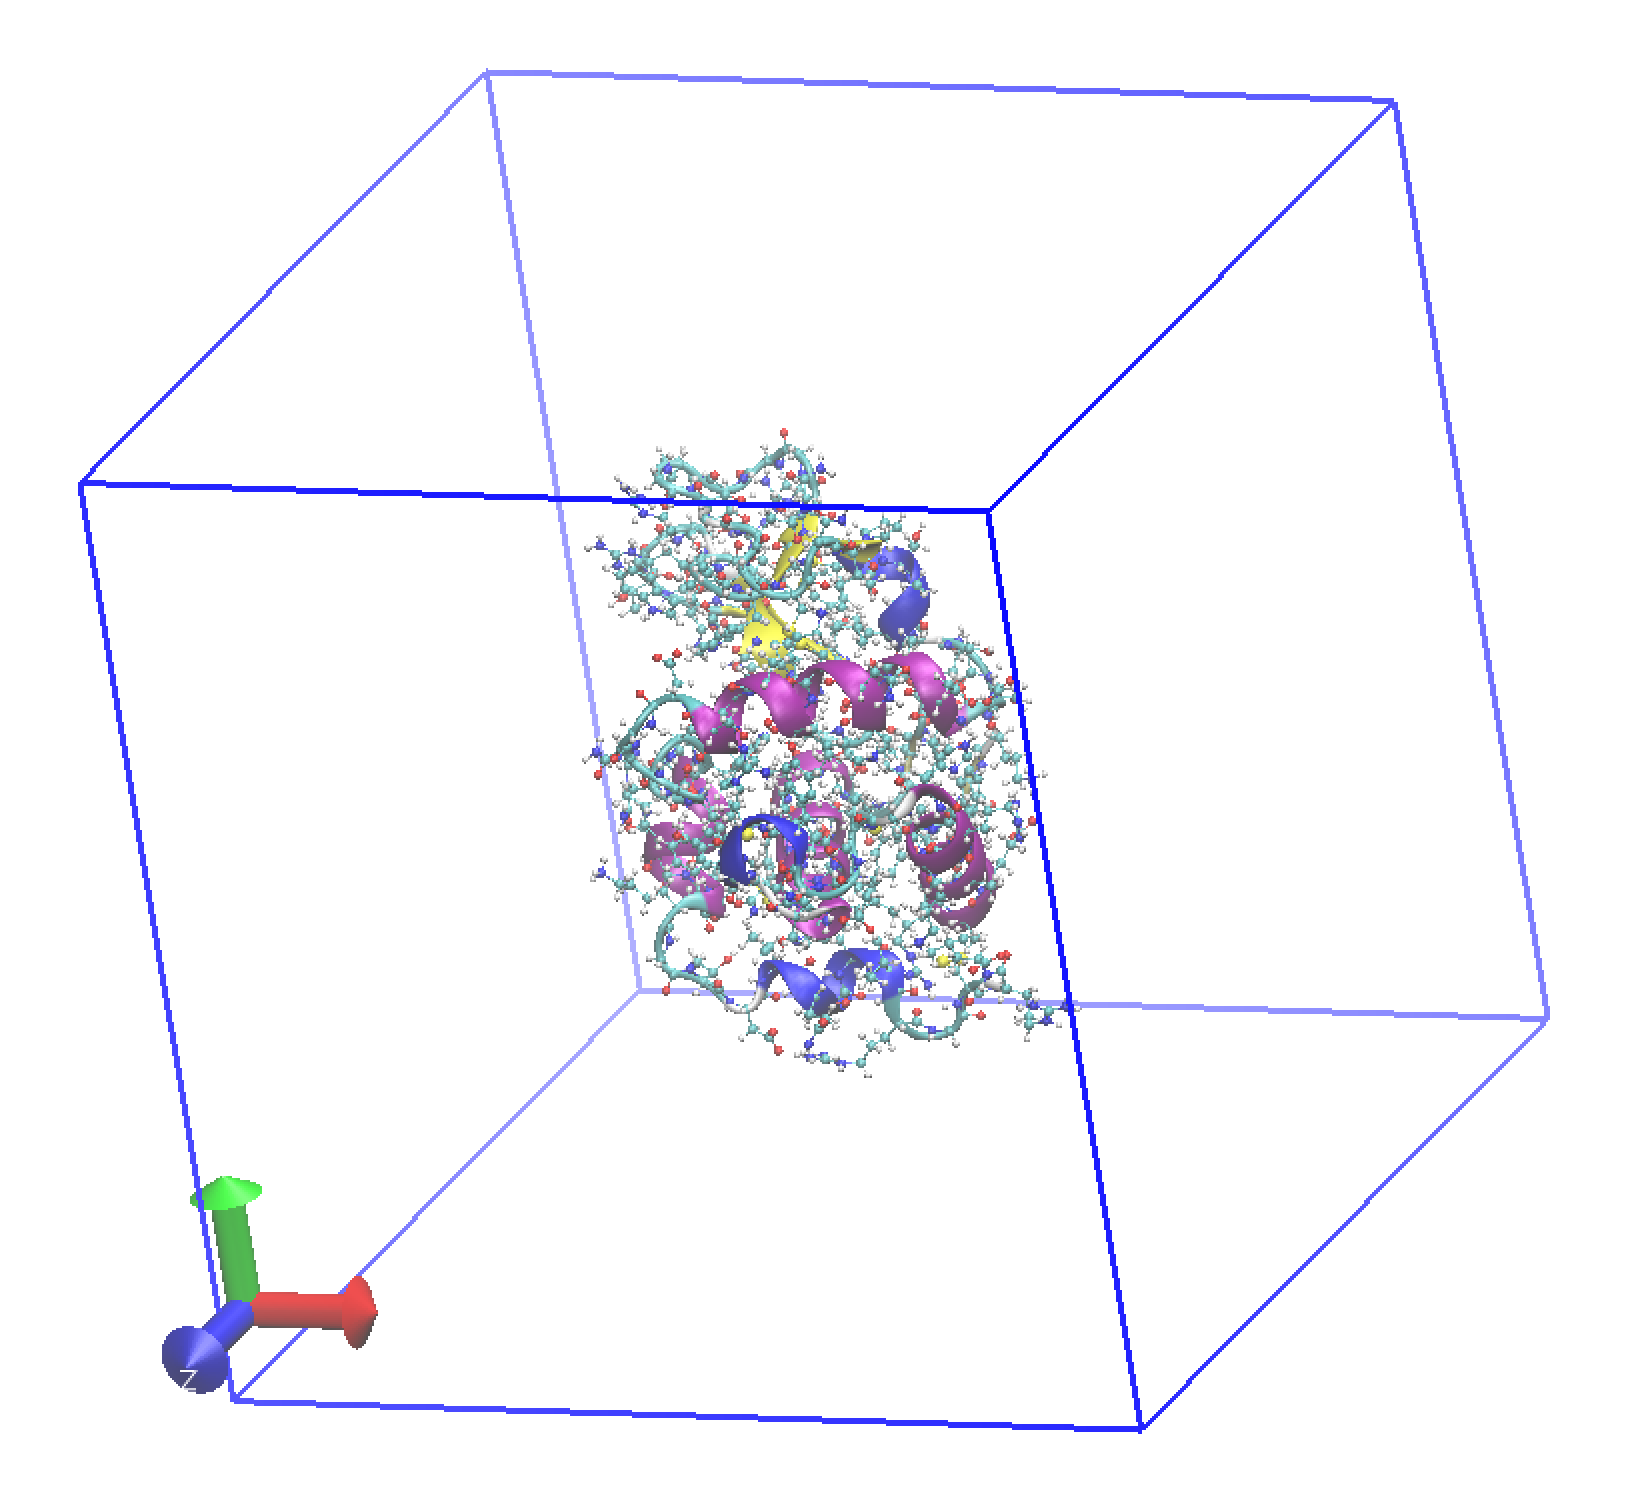

In [6]:
# Editconf: Create solvent box
# Import module
from biobb_md.gromacs.editconf import Editconf
# Create prop dict and inputs/outputs
output_editconf_gro_path = '1aki_editconf.gro'
#Create and launch bb
Editconf(input_gro_path=output_pdb2gmx_gro_path, output_gro_path=output_editconf_gro_path, properties={}).launch()
#Show log and protein
showlog()
from IPython.display import Image
Image("box.png")

## Fill the solvent box with water molecules
Fill the solvent box using the Gromacs Solvate module. The "spc216.gro" will be default solvent model. The main output of this BB will be an updated post-procesed Gromacs structure file (.gro) and a zip file containing the updated topology file (.top) and the restriction files (.itp).

In [7]:
# Solvate: Fill the box with water molecules
from biobb_md.gromacs.solvate import Solvate
# Create prop dict and inputs/outputs
output_solvate_gro_path = '1aki_solvate.gro'
output_solvate_top_zip_path = '1aki_solvate_top.zip'
#Create and launch bb
Solvate(input_solute_gro_path=output_editconf_gro_path, output_gro_path=output_solvate_gro_path, input_top_zip_path=output_pdb2gmx_top_zip_path, output_top_zip_path=output_solvate_top_zip_path,  properties={}).launch()
#Show log and protein
showlog()
view = nglview.show_file(output_solvate_gro_path)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein', color='green')
view.add_representation(repr_type='ball+stick', selection='SOL')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

2018-11-21 12:08:13,875 [MainThread  ] [INFO ]  Extracting: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/1aki_pdb2gmx_top.zip
2018-11-21 12:08:13,875 [MainThread  ] [INFO ]  to:
2018-11-21 12:08:13,876 [MainThread  ] [INFO ]  ['/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/p2g.itp', '/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/p2g.top']
2018-11-21 12:08:13,876 [MainThread  ] [INFO ]  Moving: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/p2g.top to: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/solvate.top
2018-11-21 12:08:14,115 [MainThread  ] [INFO ]  gmx solvate -cp 1aki_editconf.gro -cs spc216.gro -o 1aki_solvate.gro -p solvate.top

2018-11-21 12:08:14,115 [MainThread  ] [INFO ]  Exit code 0

2018-11-21 12:08:14,115 [MainThread  ] [INFO ]  
         based on residue and atom names, since they could not be
         definitively assigned from the informa

NGLWidget()

## Preprocess ion generation
Create the [portable binary run file (.tpr)](http://manual.gromacs.org/online/tpr.html) for ion generation, using the Grompp module. The main default parameters for this execution are:
-  integrator  = steep         ; Algorithm (steep = steepest descent minimization)
-  emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
-  emstep      = 0.01          ; Minimization step size
-  nsteps      = 50000         ; Maximum number of (minimization) steps to perform

The main output of this BB will be the portable binary run file (.tpr).

In [8]:
# Grompp: Creating portable binary run file for ion generation
from biobb_md.gromacs.grompp import Grompp
# Create prop dict and inputs/outputs
prop = {'mdp':{'type': 'minimization', 'nsteps':'50000'}}
output_gppion_tpr_path = '1aki_gppion.tpr'
#Create and launch bb
Grompp(input_gro_path=output_solvate_gro_path, input_top_zip_path=output_solvate_top_zip_path, output_tpr_path=output_gppion_tpr_path,  properties=prop).launch()
#Show log and protein
showlog(n_lines=30)

2018-11-21 12:08:46,406 [MainThread  ] [INFO ]  Extracting: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/1aki_solvate_top.zip
2018-11-21 12:08:46,407 [MainThread  ] [INFO ]  to:
2018-11-21 12:08:46,407 [MainThread  ] [INFO ]  ['/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/p2g.itp', '/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/solvate.top']
2018-11-21 12:08:46,407 [MainThread  ] [INFO ]  Moving: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/solvate.top to: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/grompp.top
2018-11-21 12:08:46,691 [MainThread  ] [INFO ]  gmx grompp -f grompp.mdp -c 1aki_solvate.gro -r 1aki_solvate.gro -p grompp.top -o 1aki_gppion.tpr -maxwarn 10

2018-11-21 12:08:46,691 [MainThread  ] [INFO ]  Exit code 0

2018-11-21 12:08:46,691 [MainThread  ] [INFO ]  
++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
J. S. Hub, B. L. de Groot

## Ion generation
Replace solvent molecules to neutralice the system and then reach a 0.05 mol/litre concentration by default. Using the Genion module.
The main output of this BB will be an updated post-procesed Gromacs structure file (.gro) and a zip file containing the updated topology file (.top) and the restriction files (.itp).

In [9]:
# Genion: Adding ions to reach a 0.05 nm concentration
from biobb_md.gromacs.genion import Genion
# Create prop dict and inputs/outputs
prop={'neutral':True, 'concentration':0.05}
output_genion_gro_path = '1aki_genion.gro'
output_genion_top_zip_path = '1aki_genion_top.zip'
#Create and launch bb
Genion(input_tpr_path=output_gppion_tpr_path, output_gro_path=output_genion_gro_path, input_top_zip_path=output_solvate_top_zip_path, output_top_zip_path=output_genion_top_zip_path, properties=prop).launch()
#Show log and protein
showlog()
view = nglview.show_file(output_genion_gro_path)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein', color='sstruc')
view.add_representation(repr_type='ball+stick', selection='NA')
view.add_representation(repr_type='ball+stick', selection='CL')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

2018-11-21 12:09:03,773 [MainThread  ] [INFO ]  To reach up 0.05 mol/litre concentration
2018-11-21 12:09:03,777 [MainThread  ] [INFO ]  Extracting: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/1aki_solvate_top.zip
2018-11-21 12:09:03,778 [MainThread  ] [INFO ]  to:
2018-11-21 12:09:03,778 [MainThread  ] [INFO ]  ['/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/p2g.itp', '/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/solvate.top']
2018-11-21 12:09:03,778 [MainThread  ] [INFO ]  Moving: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/solvate.top to: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/gio.top
2018-11-21 12:09:03,894 [MainThread  ] [INFO ]  echo "SOL" | gmx genion -s 1aki_gppion.tpr -o 1aki_genion.gro -p gio.top -neutral -conc 0.05 -seed 1993

2018-11-21 12:09:03,894 [MainThread  ] [INFO ]  Exit code 0

2018-11-21 12:09:03,894 [MainThread  ] [INFO ]  W

NGLWidget()

## Preprocess energy minimization
Create the [portable binary run file (.tpr)](http://manual.gromacs.org/online/tpr.html) for energy minimization, using the Grompp module. The main default parameters for this execution are:
-  integrator  = steep         ; Algorithm (steep = steepest descent minimization)
-  emtol       = 500.0         ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
-  emstep      = 0.01          ; Minimization step size
-  nsteps      = 50000         ; Maximum number of (minimization) steps to perform

The main output of this BB will be the portable binary run file (.tpr).

In [10]:
# Grompp: Creating portable binary run file for mdrun
from biobb_md.gromacs.grompp import Grompp
# Create prop dict and inputs/outputs
prop = {'mdp':{'type': 'minimization', 'nsteps':'50000', 'emtol':'500'}}
output_gppmin_tpr_path = '1aki_gppmin.tpr'
#Create and launch bb
Grompp(input_gro_path=output_genion_gro_path, input_top_zip_path=output_genion_top_zip_path, output_tpr_path=output_gppmin_tpr_path,  properties=prop).launch()
#Show log and protein
showlog()

2018-11-21 12:09:13,031 [MainThread  ] [INFO ]  Extracting: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/1aki_genion_top.zip
2018-11-21 12:09:13,031 [MainThread  ] [INFO ]  to:
2018-11-21 12:09:13,031 [MainThread  ] [INFO ]  ['/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/p2g.itp', '/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/gio.top', '/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/grompp.top']
2018-11-21 12:09:13,032 [MainThread  ] [INFO ]  Moving: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/gio.top to: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/grompp.top
2018-11-21 12:09:13,311 [MainThread  ] [INFO ]  gmx grompp -f grompp.mdp -c 1aki_genion.gro -r 1aki_genion.gro -p grompp.top -o 1aki_gppmin.tpr -maxwarn 10

2018-11-21 12:09:13,312 [MainThread  ] [INFO ]  Exit code 0

2018-11-21 12:09:13,312 [MainThread  ] [INFO ]  Analys

## Execute system equilibration
Execute the energy minimization using the MDrun module and the input the portable binary run file (.tpr) as the main input.
The main output of this BB will be updated structure file (.gro) and the [Gromacs trajectory file](http://manual.gromacs.org/online/trr.html) (.trr).

In [11]:
# Mdrun: Running minimization
from biobb_md.gromacs.mdrun import Mdrun
# Create prop dict and inputs/outputs
output_min_trr_path = '1aki_min.trr'
output_min_gro_path = '1aki_min.gro'
output_min_edr_path = '1aki_min.edr'
output_min_log_path = '1aki_min.log'
#Create and launch bb
Mdrun(input_tpr_path=output_gppmin_tpr_path, output_trr_path=output_min_trr_path, output_gro_path=output_min_gro_path, output_edr_path=output_min_edr_path, output_log_path=output_min_log_path, properties={}).launch()
#Show log and protein
showlog()

2018-11-21 12:10:07,790 [MainThread  ] [INFO ]  gmx mdrun -s 1aki_gppmin.tpr -o 1aki_min.trr -c 1aki_min.gro -e 1aki_min.edr -g 1aki_min.log -nt 0

2018-11-21 12:10:07,791 [MainThread  ] [INFO ]  Exit code 0



## Preprocess system temperature equilibration
Equilibrate the solvent and ions restraining the protein heavy atoms
Create the [portable binary run file (.tpr)](http://manual.gromacs.org/online/tpr.html) for system equilibration, using the Grompp module. The main default parameters for this execution are:
-  Define                   = -DPOSRES
-  integrator               = md
-  dt                       = 0.002
-  nsteps                   = 5000
-  pcoupl                   = no
-  gen_vel                  = yes
-  gen_temp                 = 300
-  gen_seed                 = -1

The main output of this BB will be the portable binary run file (.tpr).

In [12]:
# Grompp: Creating portable binary run file for Equilibration
from biobb_md.gromacs.grompp import Grompp
# Create prop dict and inputs/outputs
prop = {'mdp':{'type': 'nvt', 'nsteps':'5000'}}
output_gppnvt_tpr_path = '1aki_gppnvt.tpr'
#Create and launch bb
Grompp(input_gro_path=output_min_gro_path, input_top_zip_path=output_genion_top_zip_path, output_tpr_path=output_gppnvt_tpr_path,  properties=prop).launch()
#Show log and protein
showlog(n_lines=30)

2018-11-21 12:11:16,039 [MainThread  ] [INFO ]  Extracting: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/1aki_genion_top.zip
2018-11-21 12:11:16,039 [MainThread  ] [INFO ]  to:
2018-11-21 12:11:16,040 [MainThread  ] [INFO ]  ['/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/p2g.itp', '/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/gio.top', '/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/grompp.top']
2018-11-21 12:11:16,040 [MainThread  ] [INFO ]  Moving: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/gio.top to: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/grompp.top
2018-11-21 12:11:16,459 [MainThread  ] [INFO ]  gmx grompp -f grompp.mdp -c 1aki_min.gro -r 1aki_min.gro -p grompp.top -o 1aki_gppnvt.tpr -maxwarn 10

2018-11-21 12:11:16,459 [MainThread  ] [INFO ]  Exit code 0

2018-11-21 12:11:16,460 [MainThread  ] [INFO ]  turning all 

## Execute system temperature equilibration
Execute the system equilibration using the MDrun module and the input the portable binary run file (.tpr) as the main input.
The main output of this BB will be updated structure file (.gro) and the [Gromacs trajectory file](http://manual.gromacs.org/online/trr.html) (.trr).

In [13]:
# Mdrun: Running Equilibration NVT
from biobb_md.gromacs.mdrun import Mdrun
# Create prop dict and inputs/outputs
output_nvt_trr_path = '1aki_nvt.trr'
output_nvt_gro_path = '1aki_nvt.gro'
output_nvt_edr_path = '1aki_nvt.edr'
output_nvt_log_path = '1aki_nvt.log'
output_nvt_cpt_path = '1aki_nvt.cpt'
#Create and launch bb
Mdrun(input_tpr_path=output_gppnvt_tpr_path, output_trr_path=output_nvt_trr_path, output_gro_path=output_nvt_gro_path, output_edr_path=output_nvt_edr_path, output_log_path=output_nvt_log_path, output_cpt_path=output_nvt_cpt_path, properties={}).launch()
#Show log and protein
showlog()

2018-11-21 12:12:06,495 [MainThread  ] [INFO ]  gmx mdrun -s 1aki_gppnvt.tpr -o 1aki_nvt.trr -c 1aki_nvt.gro -e 1aki_nvt.edr -g 1aki_nvt.log -nt 0 -cpo 1aki_nvt.cpt

2018-11-21 12:12:06,496 [MainThread  ] [INFO ]  Exit code 0



## Preprocess system pressure equilibration
Equilibrate the solvent and ions restraining the protein heavy atoms.
Create the [portable binary run file (.tpr)](http://manual.gromacs.org/online/tpr.html) for system equilibration, using the Grompp module. The main default parameters for this execution are:
-  Define                   = -DPOSRES
-  integrator               = md
-  dt                       = 0.002
-  nsteps                   = 5000
-  pcoupl = Parrinello-Rahman
-  pcoupltype = isotropic
-  tau_p = 1.0
-  ref_p = 1.0
-  compressibility = 4.5e-5
-  refcoord_scaling = com
-  gen_vel = no

The main output of this BB will be the portable binary run file (.tpr).

In [14]:
# Grompp: Creating portable binary run file for mdrun
from biobb_md.gromacs.grompp import Grompp
# Create prop dict and inputs/outputs
prop = {'mdp':{'type': 'npt', 'nsteps':'5000'}}
output_gppnpt_tpr_path = '1aki_gppnpt.tpr'
#Create and launch bb
Grompp(input_gro_path=output_nvt_gro_path, input_top_zip_path=output_genion_top_zip_path, output_tpr_path=output_gppnpt_tpr_path, input_cpt_path=output_nvt_cpt_path,  properties=prop).launch()
#Show log and protein
showlog(n_lines=30)

2018-11-21 12:12:20,634 [MainThread  ] [INFO ]  Extracting: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/1aki_genion_top.zip
2018-11-21 12:12:20,634 [MainThread  ] [INFO ]  to:
2018-11-21 12:12:20,635 [MainThread  ] [INFO ]  ['/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/p2g.itp', '/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/gio.top', '/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/grompp.top']
2018-11-21 12:12:20,636 [MainThread  ] [INFO ]  Moving: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/gio.top to: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/grompp.top
2018-11-21 12:12:21,104 [MainThread  ] [INFO ]  gmx grompp -f grompp.mdp -c 1aki_nvt.gro -r 1aki_nvt.gro -p grompp.top -o 1aki_gppnpt.tpr -maxwarn 10 -t 1aki_nvt.cpt

2018-11-21 12:12:21,105 [MainThread  ] [INFO ]  Exit code 0

2018-11-21 12:12:21,105 [MainThread  ] [INFO

## Execute system pressure equilibration
Execute the system equilibration using the MDrun module and the input the portable binary run file (.tpr) as the main input.
The main output of this BB will be updated structure file (.gro) and the [Gromacs trajectory file](http://manual.gromacs.org/online/trr.html) (.trr).

In [15]:
# Mdrun: Running minimization NPT
from biobb_md.gromacs.mdrun import Mdrun
# Create prop dict and inputs/outputs
output_npt_trr_path = '1aki_npt.trr'
output_npt_gro_path = '1aki_npt.gro'
output_npt_edr_path = '1aki_npt.edr'
output_npt_log_path = '1aki_npt.log'
output_npt_cpt_path = '1aki_npt.cpt'
#Create and launch bb
Mdrun(input_tpr_path=output_gppnpt_tpr_path, output_trr_path=output_npt_trr_path, output_gro_path=output_npt_gro_path, output_edr_path=output_npt_edr_path, output_log_path=output_npt_log_path, output_cpt_path=output_npt_cpt_path, properties={}).launch()
#Show log and protein
showlog()

2018-11-21 12:13:10,583 [MainThread  ] [INFO ]  gmx mdrun -s 1aki_gppnpt.tpr -o 1aki_npt.trr -c 1aki_npt.gro -e 1aki_npt.edr -g 1aki_npt.log -nt 0 -cpo 1aki_npt.cpt

2018-11-21 12:13:10,584 [MainThread  ] [INFO ]  Exit code 0



## Preprocess free dynamics
Free molecular dynamics simulation.
Create the [portable binary run file (.tpr)](http://manual.gromacs.org/online/tpr.html) for free molecular dynamics simulation, using the Grompp module. The main default parameters for this execution are:
-  integrator               = md
-  dt                       = 0.002
-  nsteps                   = 5000

The main output of this BB will be the portable binary run file (.tpr).

In [16]:
# Grompp: Creating portable binary run file for mdrun
from biobb_md.gromacs.grompp import Grompp
# Create prop dict and inputs/outputs
prop = {'mdp':{'type': 'free', 'nsteps':'5000'}}
output_gppmd_tpr_path = '1aki_gppmd.tpr'
#Create and launch bb
Grompp(input_gro_path=output_npt_gro_path, input_top_zip_path=output_genion_top_zip_path, output_tpr_path=output_gppmd_tpr_path, input_cpt_path=output_npt_cpt_path,  properties=prop).launch()
#Show log and protein
showlog(n_lines=30)

2018-11-21 12:13:27,691 [MainThread  ] [INFO ]  Extracting: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/1aki_genion_top.zip
2018-11-21 12:13:27,692 [MainThread  ] [INFO ]  to:
2018-11-21 12:13:27,692 [MainThread  ] [INFO ]  ['/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/p2g.itp', '/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/gio.top', '/Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/grompp.top']
2018-11-21 12:13:27,693 [MainThread  ] [INFO ]  Moving: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/gio.top to: /Users/pau/projects/biobb_workflows/biobb_workflows/ubiquitin/notebooks/grompp.top
2018-11-21 12:13:28,027 [MainThread  ] [INFO ]  gmx grompp -f grompp.mdp -c 1aki_npt.gro -r 1aki_npt.gro -p grompp.top -o 1aki_gppmd.tpr -maxwarn 10 -t 1aki_npt.cpt

2018-11-21 12:13:28,028 [MainThread  ] [INFO ]  Exit code 0

2018-11-21 12:13:28,029 [MainThread  ] [INFO 

## Execute free molecular dynamics simulation
Execute the free molecular dynamics simulation  using the MDrun module and the input the portable binary run file (.tpr) as the main input.
The main output of this BB will be updated structure file (.gro) and the [Gromacs trajectory file](http://manual.gromacs.org/online/trr.html) (.trr).

In [17]:
# Mdrun: Running free dynamics
from biobb_md.gromacs.mdrun import Mdrun
# Create prop dict and inputs/outputs
output_md_trr_path = '1aki_md.trr'
output_md_gro_path = '1aki_md.gro'
output_md_edr_path = '1aki_md.edr'
output_md_log_path = '1aki_md.log'
output_md_cpt_path = '1aki_md.cpt'
#Create and launch bb
Mdrun(input_tpr_path=output_gppmd_tpr_path, output_trr_path=output_md_trr_path, output_gro_path=output_md_gro_path, output_edr_path=output_md_edr_path, output_log_path=output_md_log_path, output_cpt_path=output_md_cpt_path, properties={}).launch()
#Show log and protein
showlog()
nglview.show_simpletraj(nglview.SimpletrajTrajectory(output_md_trr_path, output_md_gro_path), gui=True)

2018-11-21 12:14:19,191 [MainThread  ] [INFO ]  gmx mdrun -s 1aki_gppmd.tpr -o 1aki_md.trr -c 1aki_md.gro -e 1aki_md.edr -g 1aki_md.log -nt 0 -cpo 1aki_md.cpt

2018-11-21 12:14:19,195 [MainThread  ] [INFO ]  Exit code 0



NGLWidget(count=2)

In [ ]:
#Clean the directory Remove everything
!find . ! \( -iname "*.ipynb" -o -iname "box.png" \) -exec rm -rf {} 2>/dev/null \; -print